In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle as pkl
from lib.utils import *
from copy import deepcopy as dcp
from os import walk
import shutil
from lib.HH_model.parameters_info import parameter_names, parameters_lower_bound,parameters_range_bounds
mpl.rcParams['font.size'] = 18
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.facecolor'] = 'w'

# CMA-ES

In [2]:
cma_p = '../Data/HH/search_tests/cmaes/'
num_std_tested = 1
init_files = []
all_std_errors = [[] for _ in range(2)]
runtime_CMA = [[] for _ in range(2)]
cma_fs =  ['cmaes_25chk_100rd_all_best_final25repeats']
for cma_f in cma_fs:
    cmaes_log = get_log(cma_p,cma_f)
    for ii in range(2):
        start_index = ii * num_std_tested
        init_file_to_search = cmaes_log[start_index]['settings']['init_file']
        print(init_file_to_search)
        init_files.append(init_file_to_search)
        for j in range(num_std_tested):
            cmaes_errors = []
            run_time = []
            sigma = cmaes_log[start_index+j]['settings']['sigma0']
            for i in range(40*num_std_tested):
                if cmaes_log[i]['settings']['init_file'] == init_file_to_search and sigma == cmaes_log[i]['settings']['sigma0'] :
                    errors = -torch.sqrt(cmaes_log[i]['fit_history']['error'])
                    run_time.append(cmaes_log[i]['overall_runtime'])
                    cmaes_errors.append(errors)
            cmaes_errors = torch.cat(cmaes_errors, dim = 0).mean(-1)
            run_time = torch.cat(run_time, dim = 0).mean(-1)
            all_std_errors[ii].append(cmaes_errors)
            runtime_CMA[ii].append(run_time.numpy())
print(all_std_errors[0][0].shape)

cube10000_0
cube10000_1
torch.Size([20, 25, 101])


# PSO

In [4]:
global_search_path_PSO = '../Data/HH/search_tests/PSO/'
PSO_paths = [
    'cube10000_0-20targets_blw0.15_chunk25_100rds_w0.5_c1.5_c0.25_0_PSO',
    'cube10000_1-20targets_blw0.15_chunk25_100rds_w0.5_c1.5_c0.5_0_PSO',
]

target_indices = [i for i in range(0,20)]
search_logs = [get_log(global_search_path_PSO, PSO_paths[i]) for i in range(len(PSO_paths))]
errors = [-torch.sqrt(search_logs[i][0]['fit_history']['error'][target_indices].mean(-1)).numpy() for i in range(len(PSO_paths))]
runtime_PSO = [search_logs[i][0]['overall_runtime'].squeeze().numpy() for i in range(len(PSO_paths))]
best_PSO_mean_errors = [errors[i].mean(1, keepdims = True).mean(0, keepdims = True) for i in range(len(PSO_paths))]
best_PSO_std_errors = [[(best_PSO_mean_errors[i]-errors[i].std(1).mean(0)).squeeze(),
                      (best_PSO_mean_errors[i]+errors[i].std(1).mean(0)).squeeze()] for i in range(len(PSO_paths))]
print(search_logs[0][0]['fit_history']['error'].shape[1], search_logs[0][0]['fit_history']['error'].shape[1])

25 25


# Random Search-based algorithms

In [5]:
sub_dir =  '../Data/HH/search_tests/simple/'

final_files = [
    [
        ['cube10000_0-20targets_sphere_w0.0_bldsphere_blw0.125_chunk25_100rds_0dim_5LD_pure', 0],
		['cube10000_0-20targets_sphere_w0.0_bldsphere_blw0.125_chunk25_100rds_0dim_5LD_SA', 1],
		['cube10000_0-20targets_sphere_w0.13_bldsphere_blw0.0_chunk25_100rds_10dim_5LD_pure_AE', 2],
		['cube10000_0-20targets_sphere_w0.2_bldsphere_blw0.0_chunk25_100rds_9dim_5LD_pure_PCA', 3],
		['cube10000_0-20targets_sphere_w0.2_bldsphere_blw0.0_chunk25_100rds_10dim_5LD_SA_AE', 4],
		['cube10000_0-20targets_sphere_w0.16_bldsphere_blw0.0_chunk25_100rds_8dim_5LD_SA_PCA', 5],
    ],[
        ['cube10000_1-20targets_sphere_w0.0_bldsphere_blw0.1_chunk25_100rds_0dim_5LD_pure', 0],
		['cube10000_1-20targets_sphere_w0.0_bldsphere_blw0.1_chunk25_100rds_0dim_5LD_SA', 1],
		['cube10000_1-20targets_sphere_w0.16_bldsphere_blw0.0_chunk25_100rds_9dim_5LD_pure_AE', 2],
		['cube10000_1-20targets_sphere_w0.2_bldsphere_blw0.0_chunk25_100rds_10dim_5LD_pure_PCA', 3],
		['cube10000_1-20targets_sphere_w0.12_bldsphere_blw0.0_chunk25_100rds_9dim_5LD_SA_AE', 4],
		['cube10000_1-20targets_sphere_w0.14_bldsphere_blw0.0_chunk25_100rds_9dim_5LD_SA_PCA', 5],
    ]
]
target_indices = [i for i in range(20)]
results = []
runtime_RS = []
global_search_path = sub_dir
random_search_paths = final_files[:4]
for ii in range(len(random_search_paths)):
    if random_search_paths[ii] is None:
        results.append(None)
        continue
    other_error = [None for _ in range(6)]
    best_other_error = [None for _ in range(6)]
    best_other_std_errors = [None for _ in range(6)]
    rt = [None for _ in range(6)]
    for j, path in enumerate(random_search_paths[ii]):
        file_er = get_log(global_search_path, path[0])
        try:
            err = -torch.sqrt(file_er[path[1]]['fit_history']['error'][target_indices][:,:,:,:].mean(-1)).numpy()
            rt[path[1]] = file_er[path[1]]['overall_runtime'].squeeze().numpy()
            other_error[path[1]] = err
            mean_err = err.mean(1, keepdims = True).mean(0, keepdims = True)
            best_other_error[path[1]] = mean_err
            best_other_std_errors[path[1]] = [(mean_err-err.std(1).mean(0)).squeeze(),
                              (mean_err+err.std(1).mean(0)).squeeze()]
        except:
            pass
    results.append([best_other_error, best_other_std_errors])
    runtime_RS.append(rt)

# Plot convergence

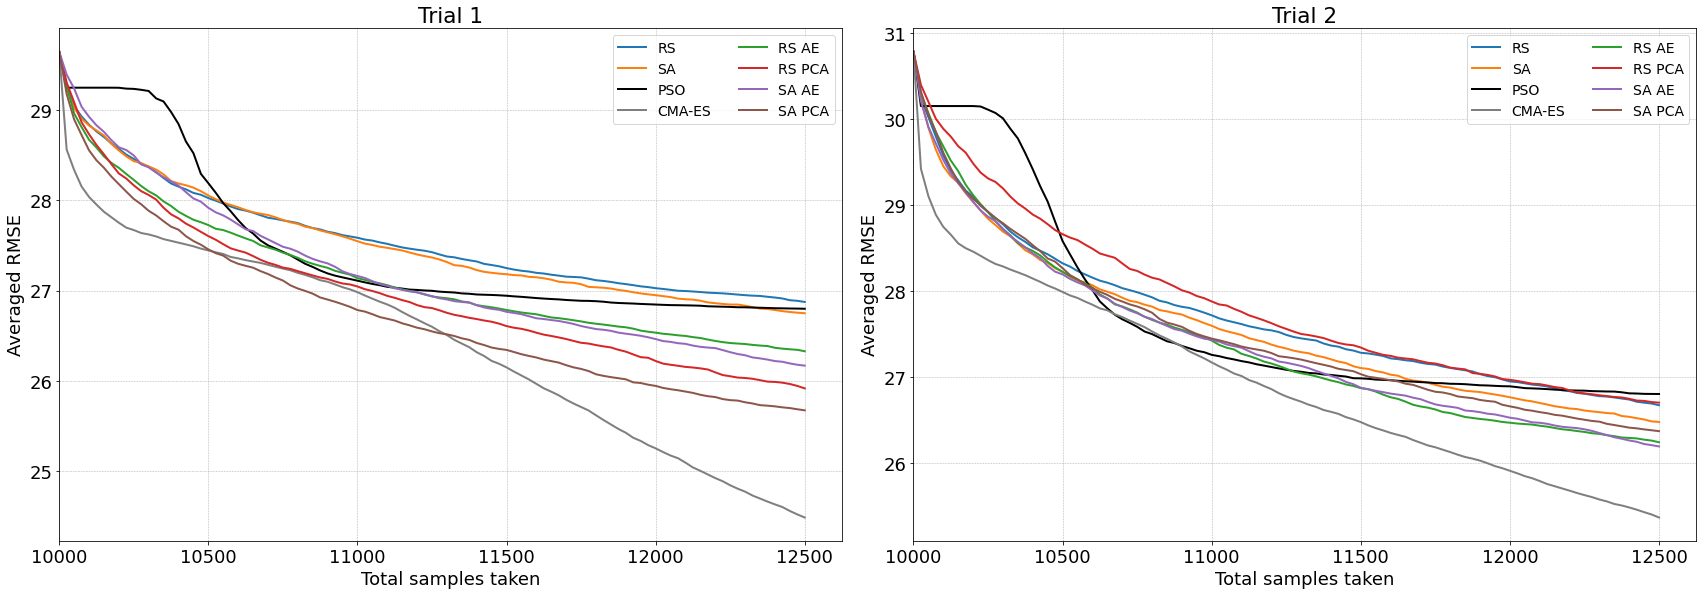

In [6]:
start = 0
titles = ['Trial 1', 'Trial 2']
loss_fn = 'correlation'
initial_samp = [10000, 10000]
num_rounds = 100
hide_pure = True
lim = num_rounds-start+1
labels = ['RS','SA','RS AE', 'RS PCA', 'SA AE', 'SA PCA']
cmae_stds = [0,0]
markers = [f'-r',f'--r','-C7',f'--C7',None,None]
ncol = 2
f = plt.figure(figsize=(24, 8* (len(results)//ncol +1)))
for i in range(len(results)):
    ax = plt.subplot(len(results)//ncol +1,ncol,i+1)
    cmae_std = cmae_stds[i]
    cmae_num = i
    if results[i] is not None:
        best_other_error = results[i][0]
        best_other_std_errors = results[i][1]
        color_num = 0
        for ii in range(0,2):
            lim = num_rounds-start+1
            samples = [initial_samp[i]+25*j for j in range(num_rounds+1)]
            plt.plot(samples,-best_other_error[ii][:,:,:lim].squeeze(), f'-C{color_num}', label = f"{labels[ii]}")
            color_num+=1
    try:
        samples = [initial_samp[i]+ 25*j for j in range(num_rounds+1)]
        plt.plot(samples,-best_PSO_mean_errors[i][:,:,:lim].squeeze(), '-k', label = f"PSO")
        plt.plot([initial_samp[i]+25*j for j in range(num_rounds+1)],-all_std_errors[cmae_num][0][:].mean(1).mean(0).numpy(),'-C7', label = f'CMA-ES')
    except:
        pass
    if results[i] is not None:
        best_other_error = results[i][0]
        best_other_std_errors = results[i][1]
        for ii in range(2,6):
            lim = num_rounds-start+1
            samples = [initial_samp[i]+25*j for j in range(num_rounds+1)]
            plt.plot(samples,-best_other_error[ii][:,:,:lim].squeeze(), f'-C{color_num}', label = f"{labels[ii]}")
            color_num+=1
    plt.xlim([initial_samp[i], None])
    plt.title(f'{titles[i]}')
    plt.ylabel(f"Averaged RMSE")
    plt.xlabel("Total samples taken")
    plt.legend(ncol = 2, prop = {'size':14})
    plt.grid(linestyle = "--", linewidth = 0.5)
#plt.suptitle("Visualizing the convergence across all targets")
plt.tight_layout()
plt.show()

# Plot run time

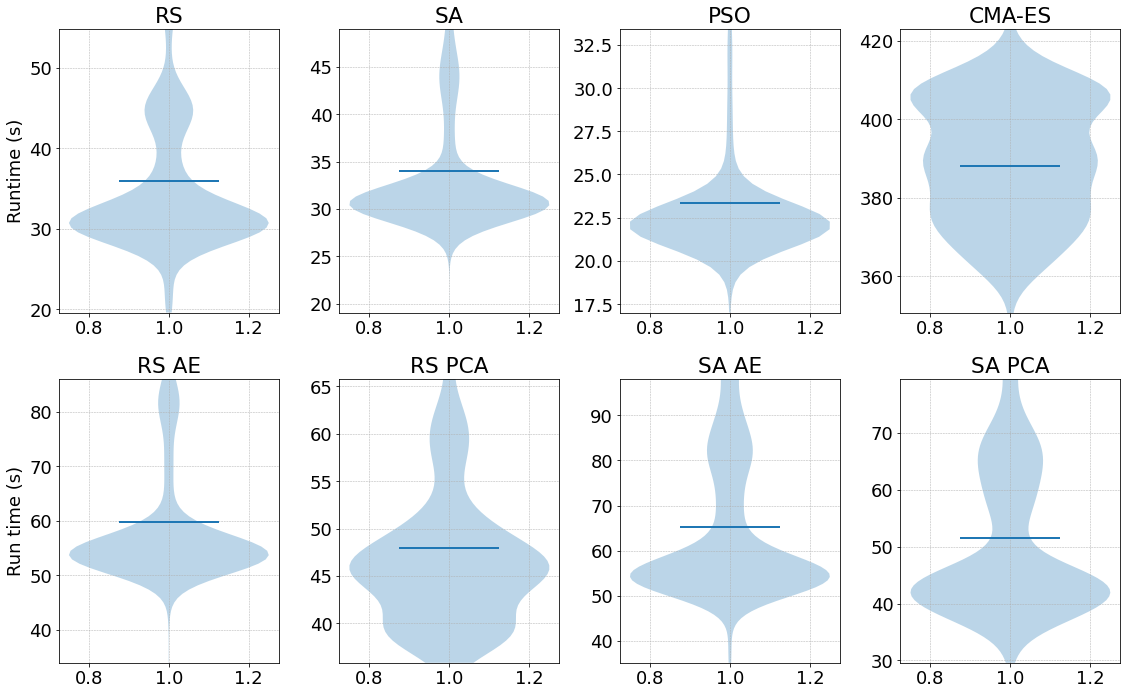

In [7]:
all_runtime_RS = [np.concatenate([runtime_RS[i][j].reshape((-1)) for i in range(2)]) for j in range(6)]
all_runtime_PSO = np.concatenate([ensure_numpy(runtime_PSO[i]).reshape((-1)) for i in range(2)])
all_runtime_CMA= np.concatenate([ensure_numpy(runtime_CMA[i][0]).reshape((-1)) for i in range(2)])
fig = plt.figure(figsize=(16,10))
for j in range(2):
    ax = plt.subplot(2,4,j+1)
    runt = ensure_numpy(all_runtime_RS[j]).reshape((-1))
    lower_b = runt.mean()-2*runt.std()
    upper_b = runt.mean()+2*runt.std()
    plt.violinplot(runt,showmeans = True, showextrema = False)
    plt.ylim([max(lower_b,runt.min()), min(upper_b,runt.max())])
    plt.grid(linestyle = "--", linewidth = 0.5)
    if j == 0:
        plt.ylabel(f"Runtime (s)")
    plt.title(f'{labels[j]}')
ax = plt.subplot(2,4,3)
lower_b = all_runtime_PSO.mean()-2*all_runtime_PSO.std()
upper_b = all_runtime_PSO.mean()+2*all_runtime_PSO.std()
plt.violinplot(all_runtime_PSO,showmeans = True, showextrema = False)
plt.ylim([max(lower_b,all_runtime_PSO.min()), min(upper_b,all_runtime_PSO.max())])
plt.grid(linestyle = "--", linewidth = 0.5)
plt.title(f'PSO')
ax = plt.subplot(2,4,4)
lower_b = all_runtime_CMA.mean()-2*all_runtime_CMA.std()
upper_b = all_runtime_CMA.mean()+2*all_runtime_CMA.std()
plt.violinplot(all_runtime_CMA,showmeans = True, showextrema = False)
plt.ylim([max(lower_b,all_runtime_CMA.min()), min(upper_b,all_runtime_CMA.max())])
plt.grid(linestyle = "--", linewidth = 0.5)
plt.title(f'CMA-ES')
for j in range(2,6):
    ax = plt.subplot(2,4,j+3)
    runt = ensure_numpy(all_runtime_RS[j]).reshape((-1))
    lower_b = runt.mean()-2*runt.std()
    upper_b = runt.mean()+2*runt.std()
    plt.violinplot(ensure_numpy(all_runtime_RS[j]).reshape((-1)),showmeans = True, showextrema = False)
    if j == 2:
        plt.ylabel(f"Run time (s)")
    plt.title(f'{labels[j]}')
    plt.ylim([max(lower_b,runt.min()), min(upper_b,runt.max())])
    plt.grid(linestyle = "--", linewidth = 0.5)
plt.tight_layout()
plt.show()